<a href="https://colab.research.google.com/github/yuvalwas/MDAN-course/blob/main/MDAN_T1_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hidden
#@title Imports
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140
import numpy as np
from scipy.stats import binom, beta, poisson, geom, norm, chi2, uniform, t as tdist
import seaborn as sns

**Models and data analysis in neuroscience - tutorial 1** <br>
Welcome to the statistics tutorial! Today we'll introduce Bayesian statistics and compare it to frequentist (classical) statistics by performing a binomial test, a common statistical procedure (that you should at least remember by name, if nothing else, from your statistics course) and seeing its Bayesian analog.

The first two tutorials deal with Bayesian analysis of binary data (e.g., whether a neuron is active or inactive). This makes it easy to convey many core concepts of Bayesian statistics while avoiding plodding through many technical details of other data types (e.g. inferring about firing rates - continuous data).

Note that code cells marked with `#hidden` don't contain interesting details, and are mainly for plotting and other technicalities. You can safely skip them without harm to your understanding of the tutorial.

# Case study 1: Binomial test
Suppose someone has a coin that we know to be a regular, unaltered coin freshly minted
by a federal government. The person flips (or spins) the coin 20 times and it happens to come up heads 17 times, that is, 85% heads. What do you believe to be the underlying
probability of heads for the coin? Despite the result from the 20 flips, the strong prior knowledge about the coin suggests that the result was likely a fluke and that the underlying probability of heads is, nevertheless, ~0.5.

**Notation**
- $n$ = number of coin flips
- $k$ = number of heads
- $p$ = probability to get heads in a single flip

## How would frequentist statistics deal with this?


The most straightforward thing to do is hypothesis testing, and specifically, a binomial test. 

### 1. Define a specific model we want to reject
First of all, we state a null hypothesis, denoted by H0 (which we want to reject) 
$$ H_0 : p = 0.5 $$
    
### 2. Build a null distribution
This distribution gives the probability to get $k$ heads out of 20 coin flips, **given $H_0$ is true**, i.e., $p=0.5$, for every $k=0,1,...,20$. This distribution is $\text{Binomial}(20, 0.5)$. Let's see it:

In [ ]:
p = 0.5 #@param 
n = 20 #@param # number of coin flips 
k = 17 #@param # heads in data
ks = np.arange(n+1) # values of k to evaluate the distribution in 
H0distribution = binom(n, p)
PMF = H0distribution.pmf(ks) # probability mass function

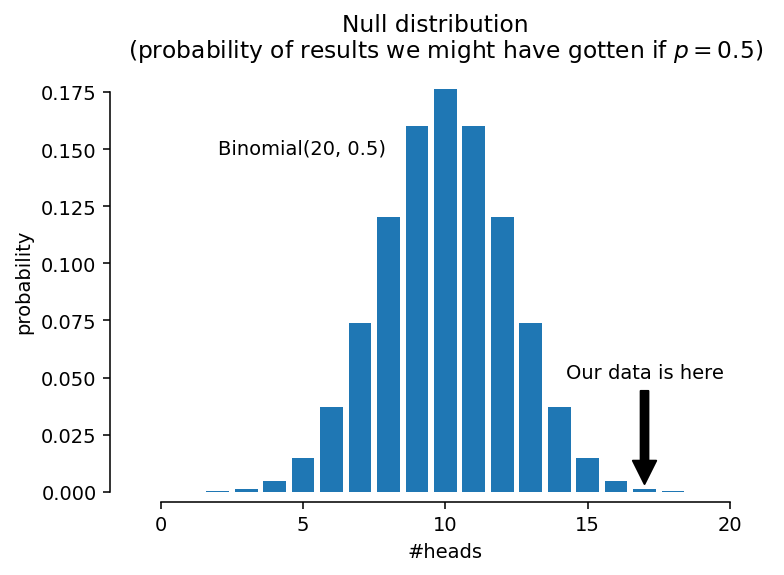

In [ ]:
#hidden
#@title Plot null distribution
plt.bar(ks, PMF)
plt.gca().set(xlabel='#heads', ylabel='probability', title=f'(probability of results we might have gotten if $p={p}$)')#')
plt.annotate("Our data is here", xy=(k, PMF[k]), xytext=(k, 0.05), 
             arrowprops = dict(facecolor ='black', shrink = 0.05),
            horizontalalignment='center')
sns.despine(trim=True, offset=5)
plt.suptitle(f'Null distribution')
plt.annotate(f'Binomial{n, p}', xy=(0.15, 0.8), xycoords='axes fraction');

### 3. Reject or retain the null hypothesis according to the probability of the data given the $H_0$ model (*likelihood*)
Now we compute the p-value. The p-value is the probability to get a result as or more extreme than what we got (again, under $H_0$). Here it is the probability to get a result $k\ge17$, or, symmetrically extreme, $k\le3$.

In [ ]:
p_value = PMF[:n-k+1].sum() + PMF[k:].sum() 
print(f'p-value = P(k≥{k} or k≤{n-k} | p=0.5) = {p_value:.3f}')

p-value = P(k≥17 or k≤3 | p=0.5) = 0.003


Because this probability is small, we conclude that our initial assumption that $p=0.5$ (H0) is probably wrong (since it led us to a very unlikely conclusion). 

### Important remarks
1. No where in the analysis did we use the fact that we are very confident that the coin is unbiased! If we would change the background story such that the coin was given to you by a magician, the analysis would have been the same.
2. Hypothesis testing doesn't tell us what model is probable. It can only tells us that $H_0$ is improbable.

**Notation warning** - too many p's!<br>
- $P(??)$ = probability of ??
- $P(?? \mid 😀)$ = probability of ??, given that 😀 is true
- $p = P$(Heads) is parameter of the distribution, the chance for heads on a single coin toss
- p-value = $P$(our result or a more extreme one $\mid\ p=0.5$)

## Bayesian statistics

**Introduction**. Moving from frequentist to Bayesian, we change the *objective* of our analysis. In frequentist statistics, our objective is to restrict the type I error probability (α, typically 5%). This means that if a 1000 researchers study false hypotheses, we'll have on average 50 of these hypotheses reported as significant. In Bayesian statistics, our objective is fundamentally different. Given prior information (here it is the prior distribution for the parameter $p$), we want to update that distribution, using the data we gathered, in an optimal way. This gives the posterior distribution.

**Bayes rule**. We remind that 
\begin{align}
 P(p \mid k=17) &\propto P(k=17 \mid p) \cdot P(p) \\
P(\text{model | data}) &\propto P(\text{data} \mid \text{model}) \cdot P(\text{model}) \\
\text{posterior} &\propto \text{likelihood} \cdot \text{prior}
\end{align}
where the $\propto$ means that the distribution on the left side *looks like* the function on the right side, it just needs to be mutliplied by some constant so that it would sum to one (but it doesn't affect the shape).<br>
We want to compute the posterior probability for every $p$ between 0 to 1, with k fixed to be as in the data. For that, let's construct the **likelihood** and the **prior**.

### Likelihood function


Likelihood is the probability of the data, given a model - e.g., the probability to of $k=17$ given that $p=0.5$. The likelihood function gives the likelihood for every $p$, i.e., it is a function of $p$ for a fixed $k$, unlike the distribution we saw above which is a function of $k$ for a fixed $p$. Although every output is a probability, it is **not a probability function** - it does not sum to one.

In [ ]:
p_step_size = 0.001 # In principle, we want the likelihood for every possible value of p between 0 and 1, however, we can only compute in with some finite resolution.
ps = np.arange(0, 1+p_step_size, p_step_size) 
likelihood = binom.pmf(k, n, ps)

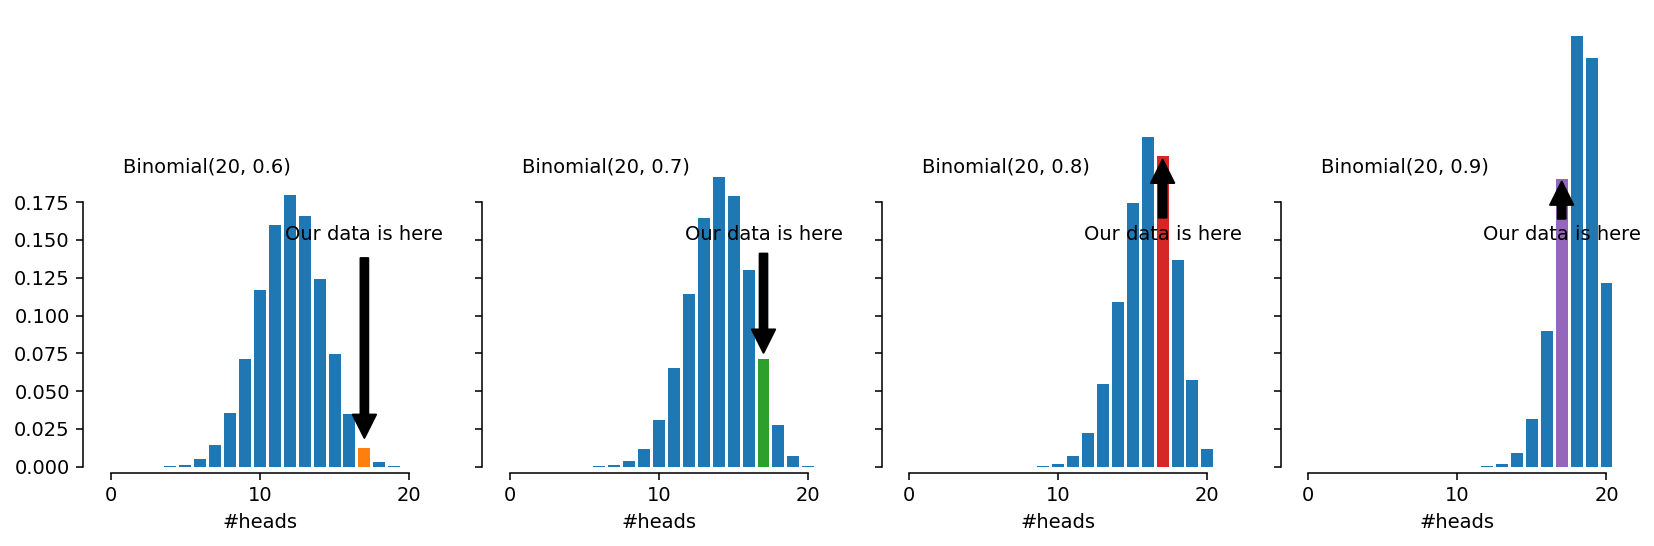

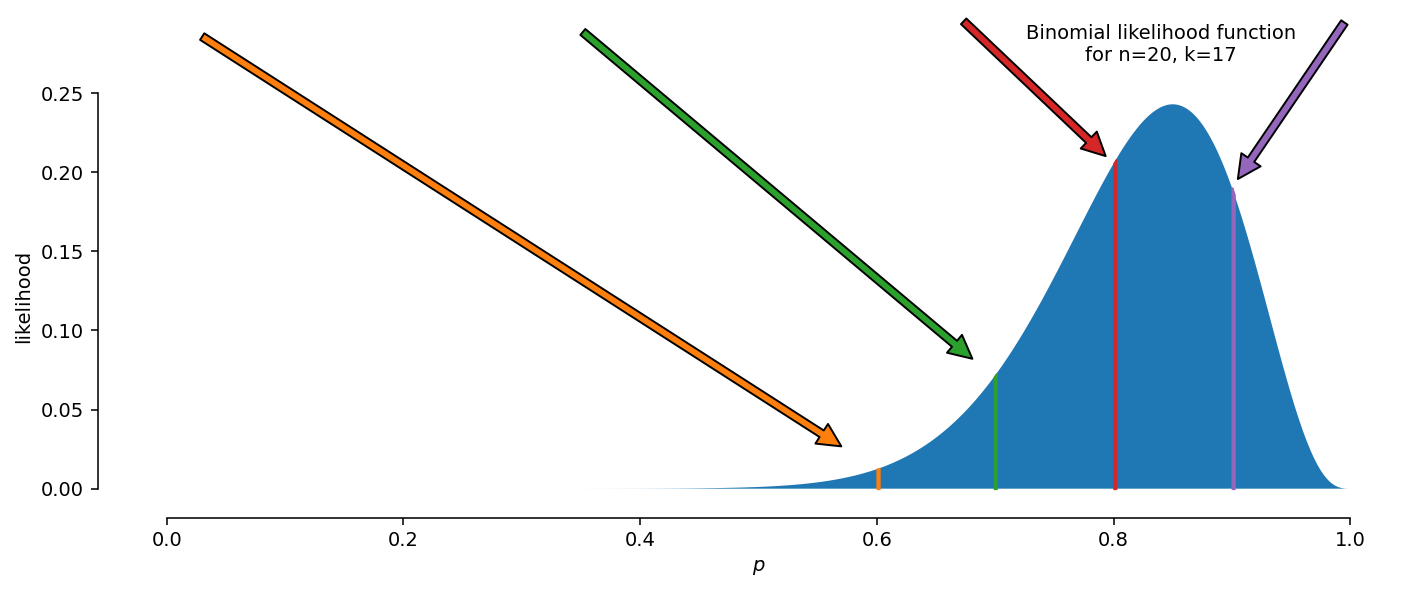

In [ ]:
#hidden
#@title Plot likelihood function
def plot_binomials(p, n, k, ax, idx):
  ks = np.arange(n+1) # values of k to evaluate the distribution in
  H0distribution = binom(n, p)
  PMF = H0distribution.pmf(ks) # probability mass function
  ax.bar(ks, PMF)
  ax.set_xlabel('#heads')
  ax.annotate("Our data is here", xy=(k, PMF[k]), xytext=(k, 0.15), 
              arrowprops = dict(facecolor ='black', shrink = 0.05),
              horizontalalignment='center')
  ax.bar(k, PMF[k], color=f'C{idx+1}')
  sns.despine(trim=True, offset=3, ax=ax)
  ax.annotate(f'Binomial{n, p}', xy=(0.1, 0.65), xycoords='axes fraction')

ps = [0.6, 0.7, 0.8, 0.9]
fig, axs = plt.subplots(1, len(ps), figsize=(12,4), sharey=True)
for idx in range(len(ps)):
  plot_binomials(ps[idx], n, k, axs[idx], idx)
axs[0].set_ylabel='probability'
plt.tight_layout()

p_step_size = 0.001
p_grid = np.arange(0, 1+p_step_size, p_step_size) # In principle, we want the likelihood for every possible value of p between 0 and 1, however, we can only compute in with some finite resolution.
likelihood = binom.pmf(k, n, p_grid)

plt.figure(figsize=(12,4))
plt.fill_between(p_grid, likelihood)

for j,p in enumerate(ps):
  idx = int(p/p_step_size)
  color = f'C{j+1}'
  plt.fill_between(p_grid[idx:idx+3], likelihood[idx:idx+3], color=color)
  plt.annotate('', xy=(p_grid[idx], likelihood[idx]), xytext=(j/3, 0.3), 
              arrowprops = dict(facecolor=color, shrink=0.05))
plt.xlabel('$p$'); plt.ylabel('likelihood')
plt.text(0.84, 0.27, f'Binomial likelihood function\nfor n={n}, k={k}', ha='center')
sns.despine(trim=True, offset=5);


### The prior distribution
The prior is the distribution of $p$ that reflects our beliefs regarding what $p$ might be, before seeing the data.  Let's assume we asked the factory about the distribution of coins, and it they informed us it is $\text{Beta}(85, 85)$. From looking at the distribution, we see that it means that many coins are very close to $p=0.5$, with some probability you can get slightly biased coins (manufacturing errors), and the probabiltiy for a major bias is almost zero.

In [ ]:
#@title Narrow prior around 0.5 - high confidence that the coin is approximately fair
α, β = 85, 85 #@param 
prior_distribution = beta(α, β) 

p_step_size = 0.001
ps = np.arange(0, 1+p_step_size, p_step_size) # In principle, we want the likelihood for every possible value of p between 0 and 1, however, we can only compute in with some finite resolution.

prior = prior_distribution.pdf(ps)
likelihood = binom.pmf(k, n, ps)

posterior = likelihood * prior
posterior /= sum(posterior) * p_step_size

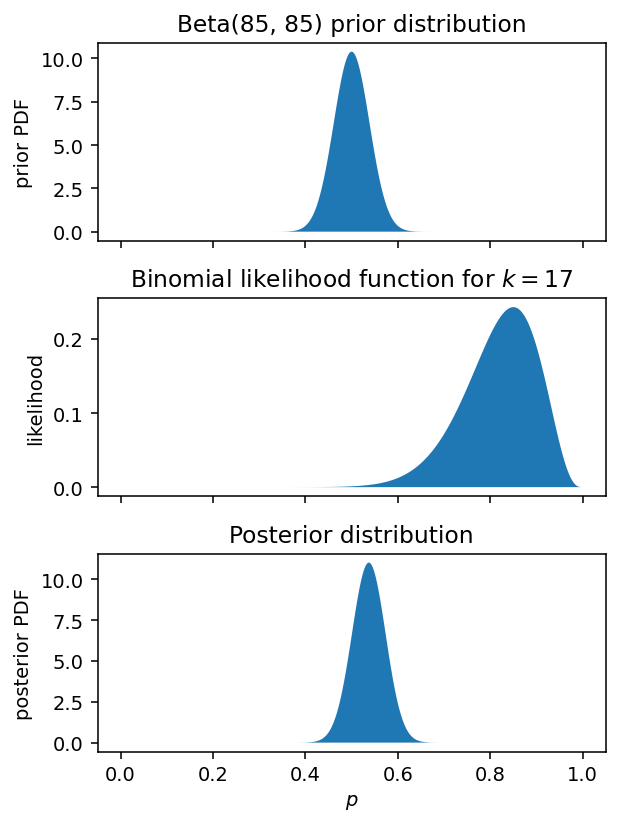

In [ ]:
#hidden
#@title plot prior
fig, axs = plt.subplots(3, 3, sharey='row', sharex='col', figsize=(12,6))
axs[0,0].fill_between(ps, prior)
axs[0,0].set_ylabel('prior PDF')
axs[0,0].set_title(f'Beta{α,β} prior distribution');
axs[1,0].fill_between(ps, likelihood)
axs[1,0].set_ylabel('likelihood')
axs[1,0].set_title(f'Binomial likelihood function for $k={k}$')
axs[2,0].fill_between(ps, posterior)
axs[2,0].set_xlabel('$p$')
axs[2,0].set_ylabel('posterior PDF')
axs[2,0].set_title('Posterior distribution')

for ax in axs.T.flatten()[3:]: ax.set_visible(False)
plt.tight_layout()

Defining the above prior means we believe that our specific coin's true $p$ was sampled from the prior distribution.

The posterior distribution is a **compromise** between the likelihood (the data) and the prior (our beliefs before seeing the data)!

What would have happened had we taken a prior with more uncertainty? And what about a flat (uniform) prior?

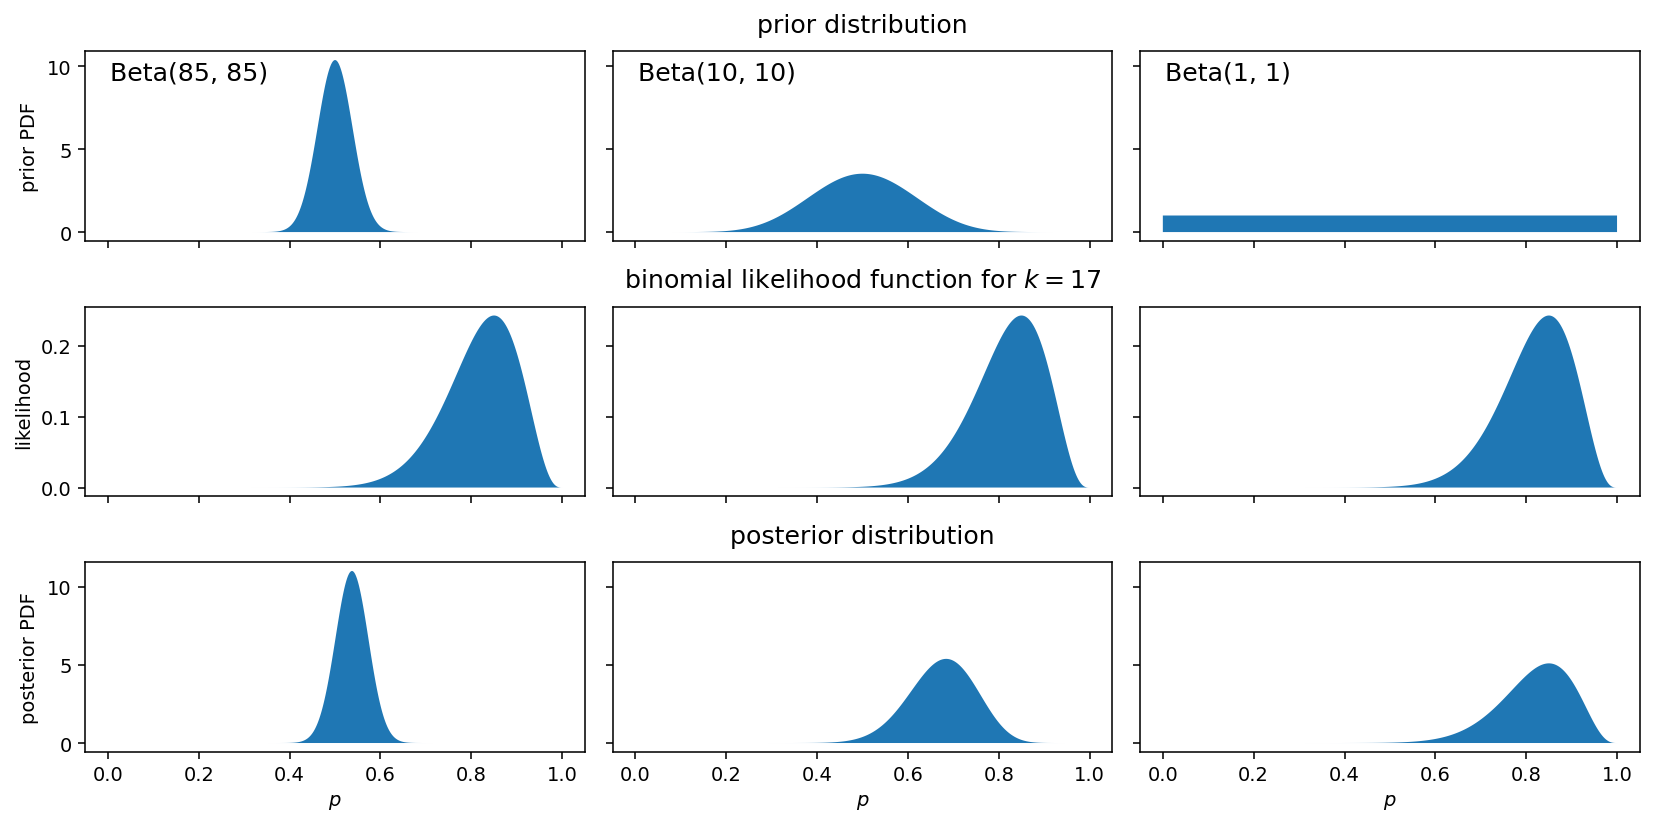

In [ ]:
#hidden
#@title Plot different priors

for ax in axs.T.flatten()[3:]: 
  ax.clear()
  ax.set_visible(True)
for ax in axs.T.flatten()[:3]: ax.set_title('')

# less certain prior
α2, β2 = 10, 10 #@param
prior_distribution = beta(α2, β2) 
prior = prior_distribution.pdf(ps)
posterior = likelihood * prior
posterior /= sum(posterior) * p_step_size

axs[0,1].fill_between(ps, prior)
axs[0,1].set_title(f'prior distribution', pad=10, fontsize=13);
axs[1,1].fill_between(ps, likelihood)
axs[1,1].set_title(f'binomial likelihood function for $k={k}$', pad=10, fontsize=13)
axs[2,1].fill_between(ps, posterior)
axs[2,1].set_xlabel('$p$')
axs[2,1].set_title('posterior distribution', pad=10, fontsize=13)

# flat prior
α3, β3 = 1, 1 #@param
prior_distribution = beta(α3, β3) 
prior = prior_distribution.pdf(ps)

posterior = likelihood * prior
posterior /= sum(posterior) * p_step_size

axs[0,2].fill_between(ps, prior)
axs[1,2].fill_between(ps, likelihood)
axs[2,2].fill_between(ps, posterior)
axs[2,2].set_xlabel('$p$')

axs[0,0].annotate(f'Beta{α, β}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=13)
axs[0,1].annotate(f'Beta{α2, β2}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=13)
axs[0,2].annotate(f'Beta{α3, β3}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=13)

fig.tight_layout()
fig

**Remarks**
1. Certainty in a prior translates to it being narrow. A narrow prior will make the compromise with likelihood, i.e. the posterior, to tend more towards the prior.
2. A *uniform prior* makes the posterior to have the same shape as the likelihood, since the likelihood is just multiplied by a constant. There is no compromise - it is 100% determined by the likelihood.
3. Sometimes a uniform/very wide prior is thought to convey a complete lack of prior knowledge and is considered conservative since it does not depend on the subjective beliefs/decisions of the researcher. Is it really so? in this scenario (and many others), it results in deciding too easily that the coin is biased, while ignoring data that we possess. Furthermore, if we really have no prior information, often frequentist statistics might have been a better thing to do.

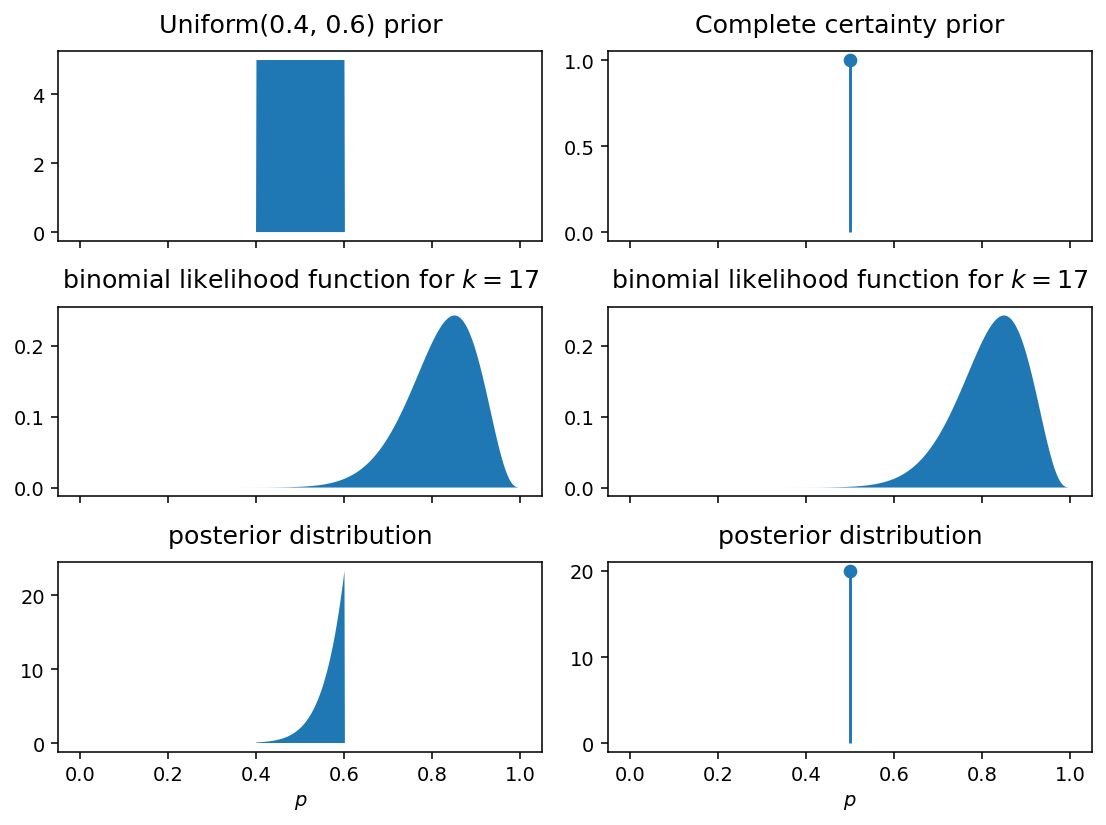

In [ ]:
#hidden
#@title Plot priors of absolute certainty
fig, axs = plt.subplots(3, 2, sharex='col', figsize=(8,6))

# uniform prior on a small interval
a, b = 0.4, 0.6
prior_distribution = uniform(a, b-a) 

p_step_size = 0.001
ps = np.arange(0, 1+p_step_size, p_step_size) # In principle, we want the likelihood for every possible value of p between 0 and 1, however, we can only compute in with some finite resolution.

prior = prior_distribution.pdf(ps)
likelihood = binom.pmf(k, n, ps)

posterior = likelihood * prior
posterior /= sum(posterior) * p_step_size

axs[0,0].fill_between(ps, prior)
axs[0,0].set_title(f'Uniform{a,b} prior', pad=10, fontsize=13);
axs[1,0].fill_between(ps, likelihood)
axs[1,0].set_title(f'binomial likelihood function for $k={k}$', pad=10, fontsize=13)
axs[2,0].fill_between(ps, posterior)
axs[2,0].set_xlabel('$p$')
axs[2,0].set_title('posterior distribution', pad=10, fontsize=13)

# delta function
prior = np.zeros(ps.shape)
prior[ps == 0.5] = 1
posterior = likelihood * prior
posterior /= sum(posterior) 

axs[0,1].stem(ps[prior>0], prior[prior>0])
axs[0,1].set_title(f'Complete certainty prior', pad=10, fontsize=13);
axs[1,1].fill_between(ps, likelihood)
axs[1,1].set_title(f'binomial likelihood function for $k={k}$', pad=10, fontsize=13)
axs[2,1].stem(ps[posterior>0], posterior[posterior>0]*20)
axs[2,1].set_xlabel('$p$')
axs[2,1].set_title('posterior distribution', pad=10, fontsize=13)

fig.tight_layout()

**We have the posterior distribution, what now? Is $p \ne 0.5$???** <br>
When we have the posterior distribution for $p$, it tells us **all** the information available about what $p$ is, while incorporating the remaining uncertainty. Suddenly, the binary question whether $p=0.5$ or not becomes less important - the distribution itself, in some sense, is the answer, because the real question all along was "what is $p$?"

**Homework Hint** <br>
For binary (coin flip) data, we usually use the Beta distribution as a prior for $p$. This has an easy interpretation:
- $\text{Beta}(1, 1)$ is identical to the uniform distribution between 0 to 1, i.e., **flat prior** (right column in the figure above)
- Using a flat prior, and coin flip data ($n$ flips, $k$ heads) the posterior distrbution comes out to be $$\text{Beta}(1 + k,\ 1+n-k) = \text{Beta}(1+\#heads,\ 1+ \#tails)$$
- More generally, using the prior $\text{Beta}(α, β)$, and coin flip data ($n$ flips, $k$ heads) the posterior distrbution comes out to be $$\text{Beta}(α+k,\ β+n-k) = \text{Beta}(α+\#heads,\ β+ \#tails)$$ 
- This emphasizes the continuous updating of knowledge that Bayesian statistics strives for. The posterior, after seeing some data, will act as the prior if we gather more data.

Those interested can read further on the topic of conjugate priors.